In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import linregress as lin
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

In [2]:
N = np.size(glob.glob("./JPL_mscn*.csv", recursive=True))
M = np.shape(np.genfromtxt('JPL_mscn017.csv', delimiter=',', skip_header=15))[0]

In [630]:
#glob.glob("./JPL_mscn*.csv", recursive=True)

In [3]:
file_n = glob.glob("./JPL_mscn*.csv", recursive=True)

data = np.empty((N, M, 2))
for i, fn in enumerate(file_n):
    file = np.genfromtxt(fn, delimiter=',', skip_header=15)
    #print(file.shape,i)
    data[i] = file

In [25]:
# Detrend
trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, data[i,:,0], data[i,:,1], bounds=((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0.0, 0.0),
                                                                  (np.inf, np.inf, np.inf, np.inf, np.inf, 2.0 * np.pi, 2.0 * np.pi)))
    trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
ddata = np.empty((N, M))
for i in range(N):
    ddata[i] = detrend(data[i,:,1], data[i,:,0], trends[i])
    
    


In [7]:
data.shape

(31, 163, 2)

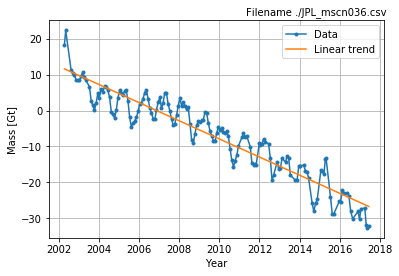

In [23]:
data_num = -1

xlist = 2002 + data[data_num-1][:,0]/365.25
tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
ylist = data[data_num-1][:,1]

trend = lin(xlist,ylist)

f, ax = plt.subplots()
ax.plot(xlist,ylist,'.-',label = 'Data')
ax.plot(xlist,xlist * trend[0] + trend[1],label = 'Linear trend')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_266", dpi=300)
plt.show()

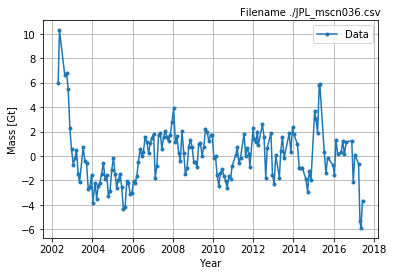

In [22]:
data_num = -1

xlist = 2002 + data[data_num-1][:,0]/365.25
tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
ylist = data[data_num-1][:,1]

detrended = detrend(ylist, data[data_num-1][:,0], trends[data_num-1])

f, ax = plt.subplots()
ax.plot(xlist,detrended,'.-',label = 'Data')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_266", dpi=300)
plt.show()

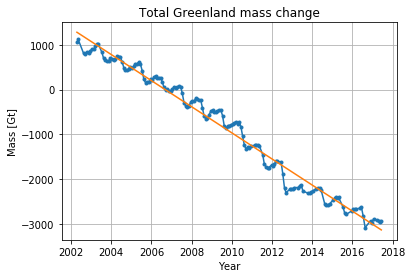

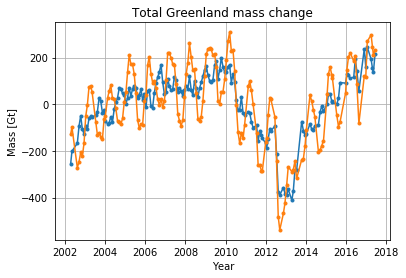

In [30]:
xlist = 2002 + data[0][:,0]/365.25
ylist = np.sum(data, axis = 0)[:,1]

total_trend = curve_fit(fit_f, data[i,:,0], ylist, bounds=((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0.0, 0.0),
                                                 (np.inf, np.inf, np.inf, np.inf, np.inf, 2.0 * np.pi, 2.0 * np.pi)))[0]
total_detrended = detrend(ylist, data[0][:,0], total_trend)

plt.plot(xlist,ylist,'.-',label = 'Data')
plt.plot(xlist,xlist * trend[0] + trend[1],label = 'Linear trend')
plt.title('Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.grid()
plt.savefig("./Pictures/timeseries_total", dpi=300)
plt.show()

plt.plot(xlist,ddata.sum(axis=0),'.-',label = 'Components Detrended')
plt.plot(xlist, total_detrended,'.-',label = 'Total Detrended')

plt.title('Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.grid()
plt.savefig("./Pictures/timeseries_detrended_total", dpi=300)
plt.show()

In [634]:
F = data[:,:,1].T
FT = np.copy(F.T)
for i in range(FT.shape[0]):
    FT[i] -= FT[i].mean()
F = np.copy(FT.T)
C = np.dot(FT, F)
evals, evecs = np.linalg.eig(C)
PCA = np.dot(F, evecs[:])

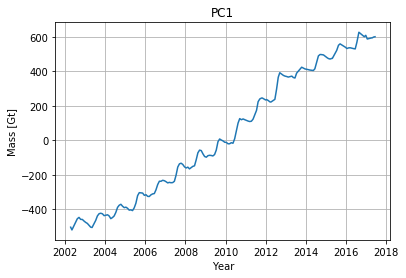

In [635]:
PCA_num = 1

plt.plot(xlist, PCA[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.title('PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures/PC%i" %PCA_num, dpi=300)
plt.show()

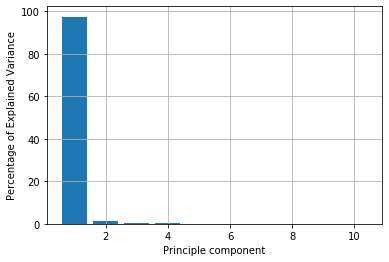

In [636]:
pca_max = 10
bars = evals / evals.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.grid()
plt.savefig("./Pictures/PC_explained", dpi=300)
plt.show()

In [637]:
R_earth = 6371*10**3
A_earth = 4*np.pi*R_earth**2
N_c = 4551
teta = np.arange(-87,90,3)
teta = 2*np.pi/360*teta

In [638]:
def dellam(teta):
    return(4*np.pi/(np.cos(teta)*N_c* 3/360*2*np.pi))

In [639]:
lamda = np.zeros((teta.size, int(2.0 * np.pi // dellam(0))))
for i in range(teta.size):
    for j in range(lamda.shape[1]):
        lamda[i,j] = (j) * dellam(teta[i])
        if lamda[i,j] >= 2*np.pi:
            lamda[i,j] = np.nan

In [640]:
#lon = np.zeros(lamda.shape)
#for i in range(lamda.shape[0]):
#    lon[i,:] = 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])

#lat = 360/(2*np.pi)*teta+1.5
#lon = 360/(2*np.pi)*lamda

In [641]:
#siz = np.size(lamda[27,:])-np.isnan(lamda[27,:]).sum()
#((siz-1)/siz * 360/(2*np.pi)*lamda[27,:]*2*np.pi/np.nanmax(lamda[27]))

In [642]:
# testcell
lon = np.zeros(lamda.shape)
for i in range(lamda.shape[0]):
    if 2*np.pi-np.max(lamda[i,:]) < 0.5*lamda[i,1]:
        lon[i,:] = 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
    else:
        siz = np.size(lamda[i,:])-np.isnan(lamda[i,:]).sum()
        lon[i,:] = (siz-1)/siz * 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
        if siz < np.size(lamda[i,:]):
            lon[i,siz] = 360

lat = 360/(2*np.pi)*teta-1.5
#lon = 360/(2*np.pi)*lamda

In [643]:
#nans = np.logical_not(np.isnan(lon[0,:]))
#print(nans)

#np.interp(lon[29], lon[0][nans], np.arange(lon[0,:].size)[nans])

In [644]:
#fit = np.zeros(lon[29].size)
#testdata = np.arange(lon[0,:].size)
#j = 0
#for i in range(fit.size):
#    if lon[29,i] > lon[0,j+1] and not np.isnan(lon[0,j+1]):
#        j += 1
#    fit[i] = testdata[j]
#fit[-1] = fit[0]
#print(fit)

In [645]:
sdata = data[:,:,1]

In [646]:
def rebin_data(data, lats, irr_lons):
    rl_sz = irr_lons[0].size
    new_sz = 721
    lonspace = np.linspace(0,360,new_sz)
    fit = np.zeros((lat.size, new_sz))
    mask = np.full((lat.size, new_sz), False)
    rlons = None
    
    for k in range(irr_lons.shape[0]):
        sz = np.sum(np.logical_not(np.isnan(irr_lons[k])))
        al = np.zeros(rl_sz)
        ml = np.full(rl_sz, True)
        rlons = irr_lons[k] if sz == irr_lons[k].size else rlons
        if k == 1:
            al[sz-3] = data[0]
            al[sz-2] = data[1]

            ml[sz-3] = False
            ml[sz-2] = False
        if k == 2:
            al[sz-5] = data[2]
            al[sz-4] = data[3]
            al[sz-3] = data[4]
            al[sz-2] = data[5]

            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
            ml[sz-2] = False
        if k == 3:
            al[sz-6] = data[6]
            al[sz-5] = data[7]
            al[sz-4] = data[8]
            al[sz-3] = data[9]

            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 4:
            al[sz-7] = data[10]
            al[sz-6] = data[11]
            al[sz-5] = data[12]
            al[sz-4] = data[13]
            al[sz-3] = data[14]

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 5:
            al[sz-7] = data[15]
            al[sz-6] = data[16]
            al[sz-5] = data[17]
            al[sz-4] = data[18]

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 6:
            al[sz-8] = data[19]
            al[sz-7] = data[20]
            al[sz-6] = data[21]
            al[sz-5] = data[22]
            al[sz-4] = data[23]

            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 7:
            al[sz-9] = data[24]
            al[sz-8] = data[25]
            al[sz-7] = data[26]
            al[sz-6] = data[27]

            ml[sz-9] = False
            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
        if k == 8:
            al[sz-9] = data[28]
            al[sz-8] = data[29]

            ml[sz-9] = False
            ml[sz-8] = False
        if k == 9:
            al[sz-9] = data[30]
            ml[sz-9] = False
        #fit = np.zeros(lon[29].size)
        j = 0
        for i in range(fit.shape[1]):
            if lonspace[i] > irr_lons[k,j+1] and not np.isnan(irr_lons[k,j+1]):
                j = min(j+1, irr_lons[k].size - 2)
            fit[k,i] = al[j]
            mask[k,i] = ml[j]
        fit[k,-1] = fit[k,0]
        mask[k,-1] = mask[k,0]
    assert(rlons is not None)
    XV, YV = np.meshgrid(lonspace, -lats)
    return XV, YV, np.ma.array(fit, mask=mask)


year = 2009.5
time = np.argmin(np.abs(xlist - year))
XV, YV, fit = rebin_data(sdata[:,time], lat, lon)

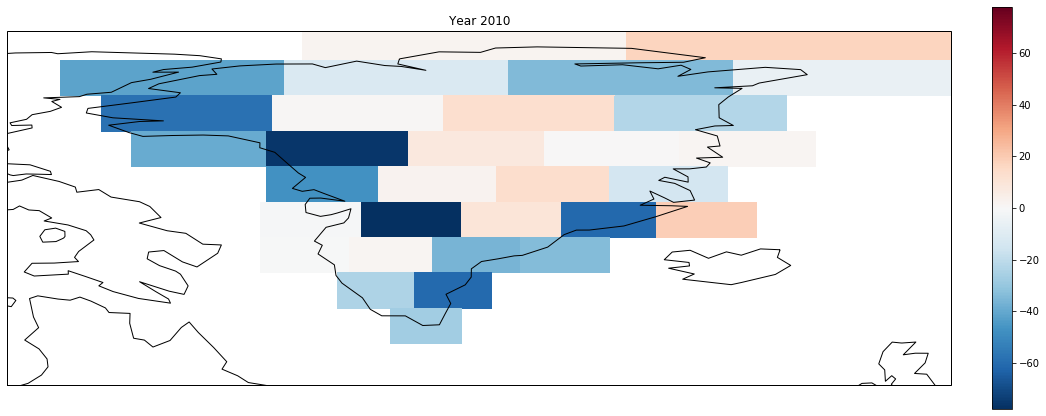

In [647]:
fig = plt.figure(figsize=(18,9))
mcmap = plt.cm.RdBu_r
mcmap.set_bad('white',1.)


ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#ax.stock_img()
ax.coastlines()
plt.axis([-80,0,55,85])
#plt.xticks(np.arange(-80,101,20),np.arange(100,281,20), fontsize=15)  
#plt.yticks(np.arange(-30,31,10), fontsize=15) 
CS = plt.pcolor(XV, YV, fit, cmap=mcmap, vmin = -np.abs(fit).max(), vmax = np.abs(fit).max())#, levels = np.arange(-130,131,20))
#for c in CS.collections:
#    c.set_edgecolor("face")
#plt.xlabel('longitude [$\degree$E]', fontsize=15)
#plt.ylabel('latitude [$\degree$N]', fontsize=15)
#plt.title('Sea surface height anomaly December 2018', fontsize=15)
plt.title("Year %.0f" % xlist[time])
plt.grid(True)
plt.colorbar(fraction=0.02, pad=0.04)

# December 2018
plt.show()

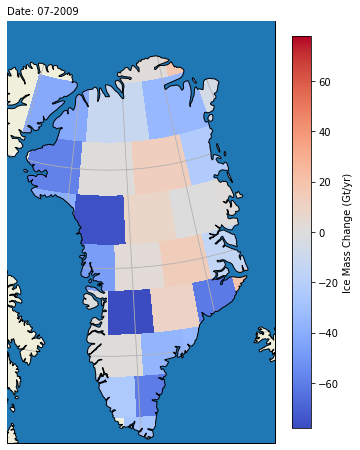

In [648]:
# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Date: %s" % tims[time].strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("Ice Mass Change (Gt/yr)")
f.savefig("./Pictures/data_%s.png" % tims[time].strftime("%m_%Y"), dpi=300)
plt.show()

In [649]:
eof_i = 1
XV, YV, eof_fit = rebin_data(evecs[:,eof_i-1], lat, lon)

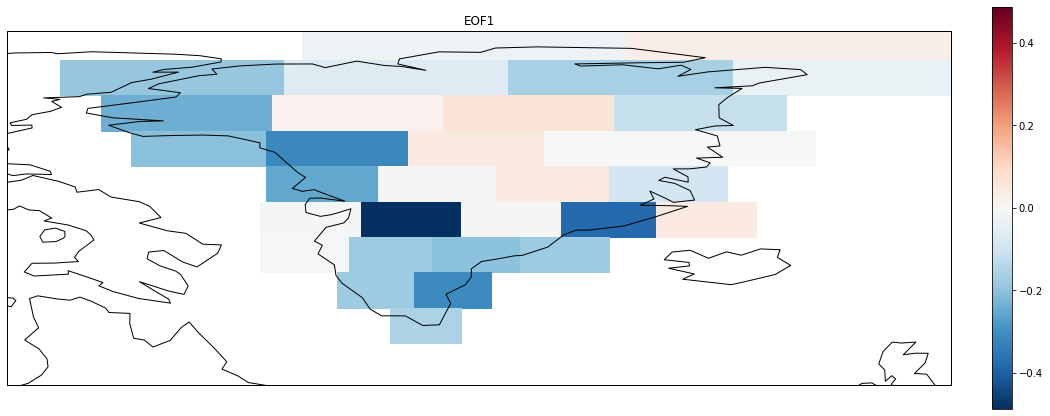

In [650]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#ax.stock_img()
ax.coastlines()
plt.axis([-80,0,55,85])
#plt.xticks(np.arange(-80,101,20),np.arange(100,281,20), fontsize=15)  
#plt.yticks(np.arange(-30,31,10), fontsize=15) 
CS = plt.pcolor(XV,YV, eof_fit, cmap=plt.cm.RdBu_r, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)))#, levels = np.arange(-130,131,20))
#for c in CS.collections:
#    c.set_edgecolor("face")
#plt.xlabel('longitude [$\degree$E]', fontsize=15)
#plt.ylabel('latitude [$\degree$N]', fontsize=15)
#plt.title('Sea surface height anomaly December 2018', fontsize=15)
plt.title('EOF' + str(eof_i))
plt.grid(True)
plt.colorbar(fraction=0.02, pad=0.04)

# December 2018
plt.show()

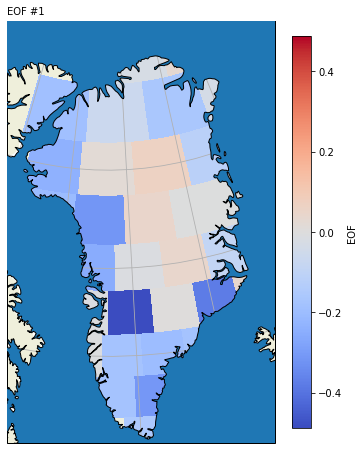

In [651]:
# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures/EOF%i.png" % eof_i, dpi=300)
plt.show()